# LPR Calendar Enrichment - License Plate Recognition Data

This notebook adds calendar features to the LPR (License Plate Recognition) data.

**LPR Data Characteristics:**
- Point-in-time vehicle detections (not parking sessions)
- Uses lot numbers (LOT 001, LOT 150, etc.)
- ~46% mapped to zone names, ~54% unmapped
- Can be used independently or combined with AMP data

**This creates a separate modeling dataset** that complements the AMP session data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

pd.set_option('display.max_columns', None)
print("Libraries loaded successfully")

Libraries loaded successfully


## Load LPR Preprocessed Data

In [2]:
# Load preprocessed LPR data
lpr_data = pd.read_csv('../data/processed/lpr_preprocessed.csv')
lpr_data['Date_Time'] = pd.to_datetime(lpr_data['Date_Time'])

print(f"Loaded {len(lpr_data):,} LPR records")
print(f"Date range: {lpr_data['Date_Time'].min().date()} to {lpr_data['Date_Time'].max().date()}")
print(f"\nColumns: {lpr_data.columns.tolist()}")

# Check mapping status
mapped = lpr_data['Zone_Name'].notna().sum()
unmapped = lpr_data['Zone_Name'].isna().sum()
print(f"\nLot Mapping Status:")
print(f"  Mapped to zones: {mapped:,} ({mapped/len(lpr_data)*100:.1f}%)")
print(f"  Unmapped: {unmapped:,} ({unmapped/len(lpr_data)*100:.1f}%)")

Loaded 1,780,391 LPR records
Date range: 2022-07-01 to 2025-06-30

Columns: ['Date_Time', 'LOT', 'Lot_number', 'Zone_Name', 'zone_type', 'location_description', 'year', 'month', 'day', 'hour', 'day_of_week', 'day_name', 'week_of_year', 'is_weekend', 'time_of_day', 'semester']

Lot Mapping Status:
  Mapped to zones: 1,780,207 (100.0%)
  Unmapped: 184 (0.0%)


## Load Calendar Data

In [3]:
# Load football games
games = pd.read_csv('../data/football_games.csv')
games['Date'] = pd.to_datetime(games['Date'])

print(f"Loaded {len(games)} home football games")
print(f"Games by year: {games.groupby('Year').size().to_dict()}")

# Load academic calendar
calendar = pd.read_csv('../data/academic_calendar.csv')
calendar['Start_Date'] = pd.to_datetime(calendar['Start_Date'])
calendar['End_Date'] = pd.to_datetime(calendar['End_Date'])

print(f"\nLoaded {len(calendar)} academic calendar events")
print(f"Event types: {calendar['Event_Type'].value_counts().to_dict()}")

Loaded 31 home football games
Games by year: {2020: 1, 2021: 7, 2022: 7, 2023: 6, 2024: 6, 2025: 4}

Loaded 82 academic calendar events
Event types: {'University_Holiday': 32, 'Semester': 16, 'Finals_Week': 11, 'Week_Of_Welcome': 6, 'Thanksgiving_Break': 6, 'Winter_Break': 6, 'Spring_Break': 5}


## Add Football Game Features

In [4]:
def add_game_features_lpr(df, games_df):
    """
    Add football game-related features to LPR data.
    
    Features:
    - is_game_day: Boolean indicating if detection was on a home game day
    - days_until_next_game: Days until next home game
    - days_since_last_game: Days since last home game
    - is_game_week: Within 3 days of a game
    """
    df = df.copy()
    
    # Extract just the date (no time) for comparison
    df['detection_date'] = df['Date_Time'].dt.date
    game_dates = set(games_df['Date'].dt.date)
    
    # Is this detection on a game day?
    df['is_game_day'] = df['detection_date'].isin(game_dates).astype(int)
    
    # Calculate days until/since games
    game_dates_sorted = sorted(games_df['Date'].dt.date)
    
    def days_to_next_game(date):
        future_games = [g for g in game_dates_sorted if g > date]
        return (future_games[0] - date).days if future_games else -1
    
    def days_from_last_game(date):
        past_games = [g for g in game_dates_sorted if g < date]
        return (date - past_games[-1]).days if past_games else -1
    
    print("Calculating days until next game...")
    df['days_until_next_game'] = df['detection_date'].apply(days_to_next_game)
    
    print("Calculating days since last game...")
    df['days_since_last_game'] = df['detection_date'].apply(days_from_last_game)
    
    # Is this within game week (3 days before or after game)?
    df['is_game_week'] = ((df['days_until_next_game'].between(0, 3)) | 
                          (df['days_since_last_game'].between(0, 3))).astype(int)
    
    df.drop('detection_date', axis=1, inplace=True)
    
    return df

# Add game features
lpr_data = add_game_features_lpr(lpr_data, games)

print("\nGame features added successfully")
print(f"\nGame day statistics:")
print(f"  Detections on game days: {lpr_data['is_game_day'].sum():,} ({lpr_data['is_game_day'].mean()*100:.2f}%)")
print(f"  Detections in game weeks: {lpr_data['is_game_week'].sum():,} ({lpr_data['is_game_week'].mean()*100:.2f}%)")

Calculating days until next game...
Calculating days since last game...

Game features added successfully

Game day statistics:
  Detections on game days: 23,801 (1.34%)
  Detections in game weeks: 229,026 (12.86%)


## Add Academic Calendar Features

In [5]:
def check_if_in_period(date, calendar_df, event_type):
    """
    Check if a date falls within a specific calendar event period.
    """
    events = calendar_df[calendar_df['Event_Type'] == event_type]
    for _, event in events.iterrows():
        if event['Start_Date'].date() <= date <= event['End_Date'].date():
            return 1
    return 0

def add_calendar_features_lpr(df, calendar_df):
    """
    Add academic calendar features to LPR data.
    
    Features:
    - is_finals_week: During finals week
    - is_spring_break: During spring break
    - is_thanksgiving_break: During Thanksgiving break
    - is_winter_break: During winter break
    - is_university_holiday: During university holiday
    - is_any_break: During any type of break period
    """
    df = df.copy()
    
    # Extract date for comparison
    df['detection_date'] = df['Date_Time'].dt.date
    
    # Check each type of calendar event
    print("Checking finals weeks...")
    df['is_finals_week'] = df['detection_date'].apply(
        lambda x: check_if_in_period(x, calendar_df, 'Finals_Week')
    )
    
    print("Checking spring breaks...")
    df['is_spring_break'] = df['detection_date'].apply(
        lambda x: check_if_in_period(x, calendar_df, 'Spring_Break')
    )
    
    print("Checking Thanksgiving breaks...")
    df['is_thanksgiving_break'] = df['detection_date'].apply(
        lambda x: check_if_in_period(x, calendar_df, 'Thanksgiving_Break')
    )
    
    print("Checking winter breaks...")
    df['is_winter_break'] = df['detection_date'].apply(
        lambda x: check_if_in_period(x, calendar_df, 'Winter_Break')
    )
    
    print("Checking university holidays...")
    df['is_university_holiday'] = df['detection_date'].apply(
        lambda x: check_if_in_period(x, calendar_df, 'University_Holiday')
    )
    
    # Combined break indicator
    df['is_any_break'] = (
        (df['is_spring_break'] == 1) |
        (df['is_thanksgiving_break'] == 1) |
        (df['is_winter_break'] == 1) |
        (df['is_university_holiday'] == 1)
    ).astype(int)
    
    df.drop('detection_date', axis=1, inplace=True)
    
    return df

# Add calendar features
lpr_data = add_calendar_features_lpr(lpr_data, calendar)

print("\nCalendar features added successfully")
print(f"\nCalendar event statistics:")
print(f"  Finals week: {lpr_data['is_finals_week'].sum():,} ({lpr_data['is_finals_week'].mean()*100:.2f}%)")
print(f"  Spring break: {lpr_data['is_spring_break'].sum():,} ({lpr_data['is_spring_break'].mean()*100:.2f}%)")
print(f"  Thanksgiving break: {lpr_data['is_thanksgiving_break'].sum():,} ({lpr_data['is_thanksgiving_break'].mean()*100:.2f}%)")
print(f"  Winter break: {lpr_data['is_winter_break'].sum():,} ({lpr_data['is_winter_break'].mean()*100:.2f}%)")
print(f"  University holiday: {lpr_data['is_university_holiday'].sum():,} ({lpr_data['is_university_holiday'].mean()*100:.2f}%)")
print(f"  Any break: {lpr_data['is_any_break'].sum():,} ({lpr_data['is_any_break'].mean()*100:.2f}%)")

Checking finals weeks...
Checking spring breaks...
Checking Thanksgiving breaks...
Checking winter breaks...
Checking university holidays...

Calendar features added successfully

Calendar event statistics:
  Finals week: 73,536 (4.13%)
  Spring break: 21,469 (1.21%)
  Thanksgiving break: 16,651 (0.94%)
  Winter break: 35,372 (1.99%)
  University holiday: 11,401 (0.64%)
  Any break: 84,893 (4.77%)


## Summary of LPR Calendar Features

In [6]:
print("="*70)
print("LPR CALENDAR ENRICHMENT SUMMARY")
print("="*70)

print(f"\nTotal LPR detections: {len(lpr_data):,}")
print(f"Date range: {lpr_data['Date_Time'].min().date()} to {lpr_data['Date_Time'].max().date()}")
print(f"Unique lots: {lpr_data['Lot_number'].nunique()}")
print(f"Mapped lots: {lpr_data['Zone_Name'].notna().sum():,} records")

print("\n" + "="*70)
print("NEW CALENDAR FEATURES:")
print("="*70)

calendar_features = [
    'is_game_day',
    'is_game_week',
    'days_until_next_game',
    'days_since_last_game',
    'is_finals_week',
    'is_spring_break',
    'is_thanksgiving_break',
    'is_winter_break',
    'is_university_holiday',
    'is_any_break'
]

for feature in calendar_features:
    if feature.startswith('days_'):
        print(f"  {feature}: numeric ({lpr_data[feature].min()} to {lpr_data[feature].max()})")
    else:
        count = lpr_data[feature].sum()
        pct = lpr_data[feature].mean() * 100
        print(f"  {feature}: {count:,} detections ({pct:.2f}%)")

print("\n" + "="*70)
print("TOP 10 LOTS BY DETECTION COUNT:")
print("="*70)

top_lots = lpr_data.groupby(['Lot_number', 'Zone_Name']).size().reset_index(name='count')
top_lots = top_lots.sort_values('count', ascending=False).head(10)
for idx, row in top_lots.iterrows():
    zone = row['Zone_Name'] if pd.notna(row['Zone_Name']) else 'Unmapped'
    print(f"  LOT {row['Lot_number']:>3} ({zone:10}):{row['count']:>8,} detections")

LPR CALENDAR ENRICHMENT SUMMARY

Total LPR detections: 1,780,391
Date range: 2022-07-01 to 2025-06-30
Unique lots: 185
Mapped lots: 1,780,207 records

NEW CALENDAR FEATURES:
  is_game_day: 23,801 detections (1.34%)
  is_game_week: 229,026 detections (12.86%)
  days_until_next_game: numeric (1 to 288)
  days_since_last_game: numeric (1 to 288)
  is_finals_week: 73,536 detections (4.13%)
  is_spring_break: 21,469 detections (1.21%)
  is_thanksgiving_break: 16,651 detections (0.94%)
  is_winter_break: 35,372 detections (1.99%)
  is_university_holiday: 11,401 detections (0.64%)
  is_any_break: 84,893 detections (4.77%)

TOP 10 LOTS BY DETECTION COUNT:
  LOT 150 (Paid      ): 179,363 detections
  LOT  71 (Paid      ): 120,727 detections
  LOT   9 (Green 1   ): 112,974 detections
  LOT  26 (Grey 1    ): 103,701 detections
  LOT 124 (Green 5   ):  95,480 detections
  LOT 146 (Paid      ):  88,426 detections
  LOT 104 (Yellow 4  ):  64,750 detections
  LOT   1 (Grey 2    ):  55,868 detections


## Visualize LPR Activity Patterns

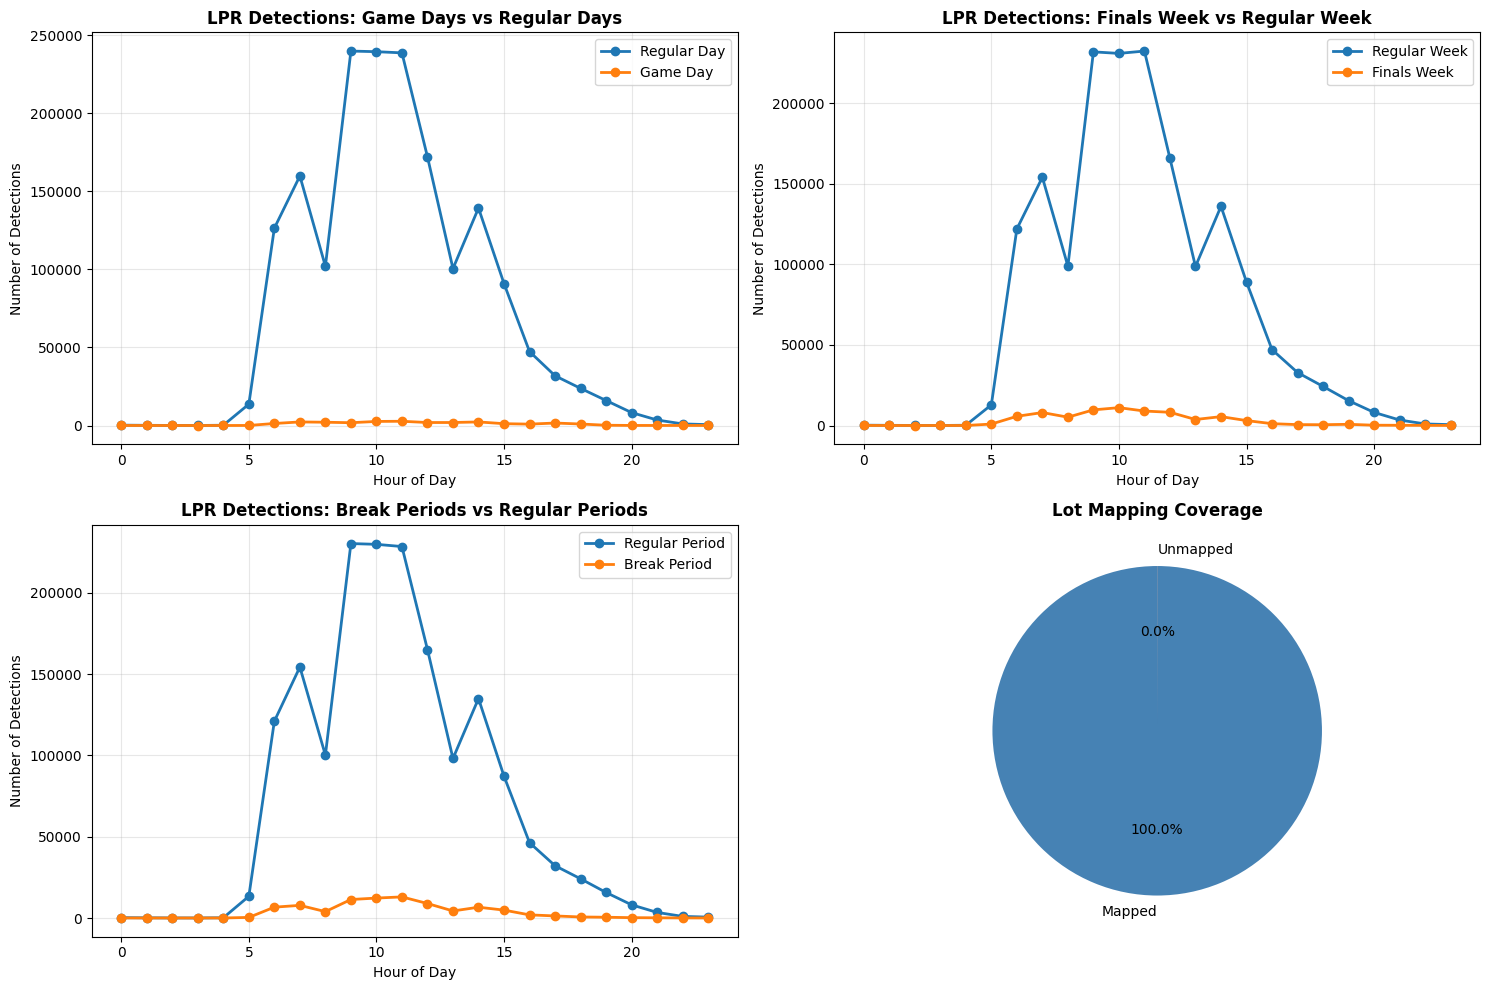

Visualization saved to: data/processed/lpr_calendar_impact_visualization.png


In [7]:
# Analyze LPR detection patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Game days vs regular days
game_day_hourly = lpr_data.groupby(['is_game_day', 'hour']).size().reset_index(name='count')
for is_game in [0, 1]:
    data = game_day_hourly[game_day_hourly['is_game_day'] == is_game]
    label = 'Game Day' if is_game else 'Regular Day'
    axes[0, 0].plot(data['hour'], data['count'], marker='o', label=label, linewidth=2)
axes[0, 0].set_title('LPR Detections: Game Days vs Regular Days', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Number of Detections')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Finals week vs regular weeks
finals_hourly = lpr_data.groupby(['is_finals_week', 'hour']).size().reset_index(name='count')
for is_finals in [0, 1]:
    data = finals_hourly[finals_hourly['is_finals_week'] == is_finals]
    label = 'Finals Week' if is_finals else 'Regular Week'
    axes[0, 1].plot(data['hour'], data['count'], marker='o', label=label, linewidth=2)
axes[0, 1].set_title('LPR Detections: Finals Week vs Regular Week', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Number of Detections')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Break periods vs regular days
break_hourly = lpr_data.groupby(['is_any_break', 'hour']).size().reset_index(name='count')
for is_break in [0, 1]:
    data = break_hourly[break_hourly['is_any_break'] == is_break]
    label = 'Break Period' if is_break else 'Regular Period'
    axes[1, 0].plot(data['hour'], data['count'], marker='o', label=label, linewidth=2)
axes[1, 0].set_title('LPR Detections: Break Periods vs Regular Periods', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Number of Detections')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Mapped vs Unmapped lots
mapped_status = ['Mapped' if pd.notna(x) else 'Unmapped' for x in lpr_data['Zone_Name']]
mapped_counts = pd.Series(mapped_status).value_counts()
colors = ['steelblue', 'coral']
axes[1, 1].pie(mapped_counts, labels=mapped_counts.index, autopct='%1.1f%%', 
               colors=colors, startangle=90)
axes[1, 1].set_title('Lot Mapping Coverage', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/processed/lpr_calendar_impact_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to: data/processed/lpr_calendar_impact_visualization.png")

## Save Enriched LPR Data

In [ ]:
# Save enriched LPR data
lpr_data.to_csv('../data/processed/lpr_enriched.csv', index=False)

print(f"Enriched LPR data saved: data/processed/lpr_enriched.csv")
print(f"  Total detections: {len(lpr_data):,}")
print(f"  Total columns: {len(lpr_data.columns)}")
print(f"  Date range: {lpr_data['Date_Time'].min().date()} to {lpr_data['Date_Time'].max().date()}")
print(f"\nNew calendar columns added:")
for feature in calendar_features:
    print(f"  - {feature}")



Enriched LPR data saved: data/processed/lpr_enriched.csv
  Total detections: 1,780,391
  Total columns: 26
  Date range: 2022-07-01 to 2025-06-30

New calendar columns added:
  - is_game_day
  - is_game_week
  - days_until_next_game
  - days_since_last_game
  - is_finals_week
  - is_spring_break
  - is_thanksgiving_break
  - is_winter_break
  - is_university_holiday
  - is_any_break

MODELING READY!

We now have two enriched datasets:
  1. amp_enriched.csv - Parking session data
  2. lpr_enriched.csv - License plate detections

Both of these include calendar features for:
  - Game days & game weeks
  - Finals weeks
  - Break periods (Spring, Thanksgiving, Winter)
  - University holidays

As We start to improve lot_mapping.csv, we can simply re-run:
  1. 02_data_preprocessing.ipynb (to update the mappings goal to 100% !)
  2. 04_lpr_calendar_enrichment.ipynb (to regenerate LPR data 1.5 hours later...)
